This notebook aims to augment the already existing pre-trained word embeddings online which maybe GloVe, Word2Vec etc, which are generalized word embeddings together with the generated hate_speech_dataset which aims to leverage these existing word embeddings to generate new word embeddings for these new words in the hate_speech_dataset which may not Exist in the vocabulary of these word embeddings themselves

# Import Libraries

In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import one_hot


from utilities.data_preprocessors import read_preprocess, series_to_1D_array, construct_embedding_dict, construct_embedding_matrix
from utilities.data_visualizers import train_cross_results_v2, view_final_metrics
from models.model_arcs import load_lstm_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# 1 for religious and 0 for non religious
df = pd.read_csv('./data/hate-speech-data-cleaned.csv', index_col=0)
df = read_preprocess(df)

df['label'].value_counts()

2    22395
1    21644
0    19743
3     1998
Name: label, dtype: int64

In [31]:
all_words = pd.Series(series_to_1D_array(df['comment']))
all_unique_words_counts = all_words.value_counts()
all_unique_words = all_words.unique()

In [32]:
len(all_words)

894878

In [33]:
len(all_unique_words)

47921

In [34]:
all_unique_words_counts

nigger         16186
faggot         14812
bitch          12246
tranny         11850
like           11657
               ...  
pty                1
vocorp             1
sometimesin        1
shon               1
maupin             1
Length: 47921, dtype: int64

In [35]:
# before joining again get array in df with longest length first
max_len_1 = len(max(df['comment'], key=len))
type(max_len_1)

int

In [36]:
max_len_1

503

# Details about the dataframe
in summary classes are now to be the ff:
- NEITHER 1
- OFFENSIVE 0
- HATE 2
- HOMONYM 3

In [37]:
df['comment'] = df['comment'].apply(lambda comment: " ".join(comment))
df

,comment,label
0,woman complain cleaning house man always take ...,1
1,boy dat coldtyga dwn bad cuffin dat hoe st place,0
2,dawg ever fuck bitch start cry confused shit,0
3,look like tranny,0
4,shit hear might true might faker bitch told ya,0
...,...,...
65775,from the midnight sun where the hot spring blow,1
65776,do not say am not your type,1
65777,and therefor never send to know for whom the b...,1
65778,and cannot stand anoth day,1


In [38]:
df.loc[0, 'comment']

'woman complain cleaning house man always take trash'

In [39]:
df['label'].value_counts()

2    22395
1    21644
0    19743
3     1998
Name: label, dtype: int64

# Preparing data for training classifier
**A note on the subsequent code below**

fit_on_texts Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

In [40]:
# train_sents, test_sents, train_labels, test_labels = train_test_split(df['comment'], df['label'], test_size=0.3, random_state=0)
sents = df['comment']
max_len_2 = 50

num_words_1 = df.shape[0]
num_words_2 = len(all_words)
num_words_3 = len(all_unique_words)

tokenizer = Tokenizer(num_words=num_words_3, split=' ')
tokenizer.fit_on_texts(sents)
# the bug is here that's why there are wrong indeces

seqs = tokenizer.texts_to_sequences(sents)

# post means place padding of 0's on the tail or ending of the sequence
# and truncating removes the values of a sequence that is greater than the max length given
seqs_padded = pad_sequences(seqs, maxlen=max_len_1, padding='post', truncating='post')

In [41]:
# at the same time one hot encode the y labels/classes
len_unique_labels = len(df['label'].unique())
Y_oh = one_hot(df['label'], len_unique_labels).numpy()
Y_oh

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [42]:
seqs

[[42, 1301, 3583, 264, 46, 96, 76, 93],
 [158, 405, 21627, 15991, 72, 6673, 405, 13, 1041, 186],
 [2023, 87, 12, 3, 182, 402, 793, 15],
 [39, 5, 4],
 [15, 271, 153, 280, 153, 8250, 3, 178, 202],
 [15, 843, 21628, 3887, 509, 52, 18, 13],
 [808, 57, 141, 3, 24, 58, 15, 61],
 [176, 840, 142, 3, 400, 26, 1302, 67],
 [153, 8, 202, 3, 64, 209],
 [3258, 2183, 1062, 15992, 3],
 [21629, 3, 4007, 114, 55, 1332, 735, 5, 604],
 [9989, 1574, 3, 1574, 1662],
 [13, 1076, 988, 670, 29, 2400],
 [72, 3, 33, 5],
 [3, 8],
 [3, 37, 719],
 [3, 3888, 334],
 [3, 63],
 [3, 8, 455, 1042, 361],
 [14, 1716, 72, 3],
 [452, 3, 318, 90, 132],
 [4145, 3, 5, 9038],
 [318, 43, 13, 221, 214],
 [12, 3, 94, 28, 220, 78, 11288, 180, 389, 12, 2400],
 [24, 202, 3, 1533, 13072, 21630, 1833],
 [35, 1303, 5, 2851, 736],
 [13, 1641],
 [690, 35, 3324, 2459, 554, 35, 1377],
 [59, 11289, 3, 12, 15993],
 [1053, 192, 27, 3, 658],
 [11290, 98, 3, 119, 3, 35, 11291],
 [7, 10, 84, 64, 98, 98, 3, 7, 8, 2460],
 [79, 389, 970, 137, 35, 37,

Here we see that indeed 50 is not enough as our max length but for the subsequent code we will still use 50 and later 503 for our experimentation. For now 503 will be an extremely large value eespecially when applied to all sequences

In [43]:
print(max_len_1, max_len_2)

503 50


In [44]:
word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word
print(len(word_to_index))

47916


In [45]:
word_to_index

{'nigger': 1,
 'faggot': 2,
 'bitch': 3,
 'tranny': 4,
 'like': 5,
 'people': 6,
 'would': 7,
 'get': 8,
 'word': 9,
 'say': 10,
 'one': 11,
 'fuck': 12,
 'hoe': 13,
 'black': 14,
 'shit': 15,
 'know': 16,
 'think': 17,
 'fucking': 18,
 'call': 19,
 'time': 20,
 'guy': 21,
 'make': 22,
 'white': 23,
 'got': 24,
 'gay': 25,
 'u': 26,
 'want': 27,
 'even': 28,
 'go': 29,
 'called': 30,
 'someone': 31,
 'really': 32,
 'thing': 33,
 'said': 34,
 'pussy': 35,
 'as': 36,
 'nigga': 37,
 'use': 38,
 'look': 39,
 'right': 40,
 'trannies': 41,
 'woman': 42,
 'see': 43,
 'saying': 44,
 'racist': 45,
 'man': 46,
 'way': 47,
 'cannot': 48,
 'good': 49,
 'calling': 50,
 'mean': 51,
 'still': 52,
 'never': 53,
 'also': 54,
 'lol': 55,
 'person': 56,
 'hate': 57,
 'much': 58,
 'need': 59,
 'could': 60,
 'going': 61,
 'used': 62,
 'love': 63,
 'back': 64,
 'year': 65,
 'day': 66,
 'girl': 67,
 'something': 68,
 'well': 69,
 'op': 70,
 'friend': 71,
 'bad': 72,
 'every': 73,
 'let': 74,
 'actually': 75,

In [46]:
index_to_word

{1: 'nigger',
 2: 'faggot',
 3: 'bitch',
 4: 'tranny',
 5: 'like',
 6: 'people',
 7: 'would',
 8: 'get',
 9: 'word',
 10: 'say',
 11: 'one',
 12: 'fuck',
 13: 'hoe',
 14: 'black',
 15: 'shit',
 16: 'know',
 17: 'think',
 18: 'fucking',
 19: 'call',
 20: 'time',
 21: 'guy',
 22: 'make',
 23: 'white',
 24: 'got',
 25: 'gay',
 26: 'u',
 27: 'want',
 28: 'even',
 29: 'go',
 30: 'called',
 31: 'someone',
 32: 'really',
 33: 'thing',
 34: 'said',
 35: 'pussy',
 36: 'as',
 37: 'nigga',
 38: 'use',
 39: 'look',
 40: 'right',
 41: 'trannies',
 42: 'woman',
 43: 'see',
 44: 'saying',
 45: 'racist',
 46: 'man',
 47: 'way',
 48: 'cannot',
 49: 'good',
 50: 'calling',
 51: 'mean',
 52: 'still',
 53: 'never',
 54: 'also',
 55: 'lol',
 56: 'person',
 57: 'hate',
 58: 'much',
 59: 'need',
 60: 'could',
 61: 'going',
 62: 'used',
 63: 'love',
 64: 'back',
 65: 'year',
 66: 'day',
 67: 'girl',
 68: 'something',
 69: 'well',
 70: 'op',
 71: 'friend',
 72: 'bad',
 73: 'every',
 74: 'let',
 75: 'actually',

In [47]:
seqs[0]

[42, 1301, 3583, 264, 46, 96, 76, 93]

In [48]:
# this is supposed to be 1301
print(word_to_index['complain'])

# this is supposed to be 3583
print(word_to_index['cleaning'])

1301
3583


In [49]:
seqs_padded

array([[   42,  1301,  3583, ...,     0,     0,     0],
       [  158,   405, 21627, ...,     0,     0,     0],
       [ 2023,    87,    12, ...,     0,     0,     0],
       ...,
       [  241,  8741,    53, ...,     0,     0,     0],
       [  241,    48,   430, ...,     0,     0,     0],
       [  936, 11286,   372, ...,     0,     0,     0]])

In [50]:
train_seqs, _seqs, train_labels, _labels = train_test_split(seqs_padded, Y_oh, test_size=0.3, random_state=0)
val_seqs, test_seqs, val_labels, test_labels = train_test_split(_seqs, _labels, test_size=0.5, random_state=0)

train_seqs

array([[   80,    37,    15, ...,     0,     0,     0],
       [  197,   632,   322, ...,     0,     0,     0],
       [ 1702,    19,   618, ...,     0,     0,     0],
       ...,
       [ 7031,  2718,   133, ...,     0,     0,     0],
       [   89, 38309,   100, ...,     0,     0,     0],
       [  268,  2005,     1, ...,     0,     0,     0]])

In [51]:
train_seqs.shape

(46046, 503)

In [52]:
val_seqs

array([[  173,    80, 32098, ...,     0,     0,     0],
       [  295,     3,  1047, ...,     0,     0,     0],
       [   53,    16,   322, ...,     0,     0,     0],
       ...,
       [    7,    53, 39840, ...,     0,     0,     0],
       [ 1117,    22,   626, ...,     0,     0,     0],
       [  340,     3,  6730, ...,     0,     0,     0]])

In [53]:
len(val_seqs)

9867

# Loading the Big Guns 
or the 1.9 million word vocabulary and its 300 dimensional embeddings

In [54]:
# important variables

# includes oov words
vocab_len = len(word_to_index) + 1
emb_dict, emb_vec_len = construct_embedding_dict('./embeddings/glove.42B.300d.txt', word_to_index)
emb_matrix = construct_embedding_matrix(word_to_index, emb_dict, emb_vec_len)
lstm_model = load_lstm_model(max_len_1, vocab_len, emb_matrix)

100%|██████████| 47916/47916 [00:00<00:00, 247143.37it/s]


input shape: 503


In [55]:
lstm_model.summary()

Model: "hate-speech-lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 503)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 503, 300)          14375100  
                                                                 
 lstm_2 (LSTM)               (None, 503, 128)          219648    
                                                                 
 dropout_2 (Dropout)         (None, 503, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)            

In [56]:
emb_matrix.shape

(47917, 300)

In [57]:
lstm_history = lstm_model.fit(
    train_seqs, train_labels,
    epochs=100,
    validation_data=(val_seqs, val_labels),
    callbacks=[EarlyStopping(monitor='val_categorical_crossentropy', patience=10)]
)

# build the dictionary of results based on metric history of both models
lstm_results = {}
for metric in ['loss', 'categorical_crossentropy', 'categorical_accuracy', 'val_loss', 'val_categorical_crossentropy', 'val_categorical_accuracy']:
    if metric not in lstm_results:
        lstm_results[metric] = lstm_history.history[metric]

Epoch 1/100
1439/1439 [==============================] - 1327s 914ms/step - loss: 1.2068 - categorical_crossentropy: 1.2068 - categorical_accuracy: 0.3319 - val_loss: 1.2004 - val_categorical_crossentropy: 1.2004 - val_categorical_accuracy: 0.3232
Epoch 2/100
1439/1439 [==============================] - 1308s 909ms/step - loss: 1.2028 - categorical_crossentropy: 1.2028 - categorical_accuracy: 0.3328 - val_loss: 1.2019 - val_categorical_crossentropy: 1.2019 - val_categorical_accuracy: 0.3232
Epoch 3/100
1439/1439 [==============================] - 1288s 895ms/step - loss: 1.2021 - categorical_crossentropy: 1.2021 - categorical_accuracy: 0.3365 - val_loss: 1.2005 - val_categorical_crossentropy: 1.2005 - val_categorical_accuracy: 0.3232
Epoch 4/100
1439/1439 [==============================] - 1285s 893ms/step - loss: 1.2022 - categorical_crossentropy: 1.2022 - categorical_accuracy: 0.3345 - val_loss: 1.1997 - val_categorical_crossentropy: 1.1997 - val_categorical_accuracy: 0.3441
Epoch 5/

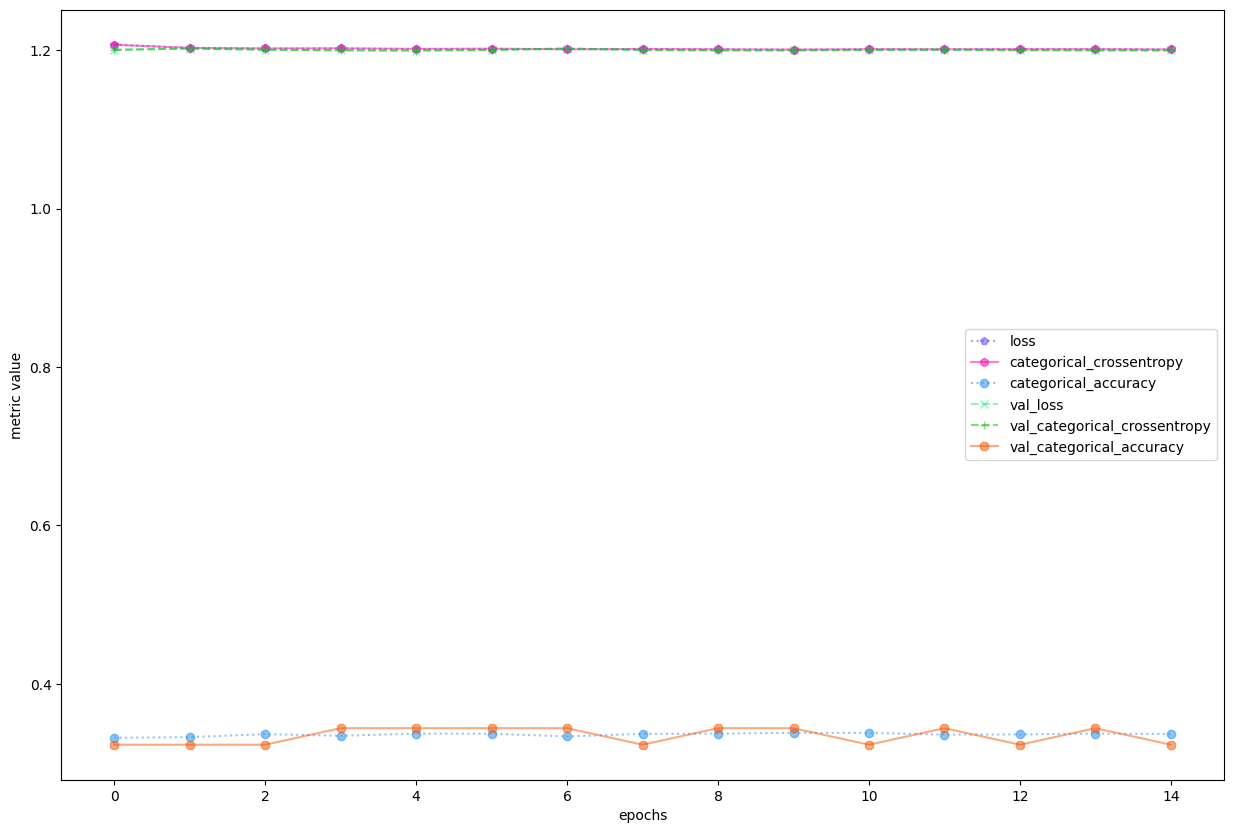

In [58]:
train_cross_results_v2(lstm_results, epochs=lstm_history.epoch[-1])

In [59]:
# # display values from last epoch of baseline model
# view_final_metrics(baseline_results_orig, 'LSTM NEURAL NETWORK RESULTS')
# view_final_metrics(baseline_results_red, 'SOFTMAX REGRESSION CLASSIFIER RESULTS')